In [27]:
import os
import json
from typing import Annotated, TypedDict
from dotenv import load_dotenv
from langchain.embeddings import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams

In [11]:
load_dotenv()
qdrant_key = os.getenv("QDRANT_KEY")
qdrant_url = os.getenv("QDRANT_URL")

In [12]:
def preprocess_dataset(docs_list):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=700,
        chunk_overlap=50,
        disallowed_special=()
    )
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits

In [13]:
hugging_face_doc = HuggingFaceDatasetLoader("m-ric/huggingface_doc","text")
transformers_doc = HuggingFaceDatasetLoader("m-ric/transformers_documentation_en","text")

In [ ]:
number_of_docs=50
hf_splits = preprocess_dataset(hugging_face_doc.load()[:number_of_docs])
transformer_splits = preprocess_dataset(transformers_doc.load()[:number_of_docs])

# Agent

In [17]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_qdrant import QdrantVectorStore

def create_retriever(collection_name, doc_splits):
    vectorstore = QdrantVectorStore.from_documents(
        doc_splits,
        HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"),
        url=qdrant_url,
        api_key=qdrant_key,
        collection_name=collection_name,
    )
    return vectorstore.as_retriever()

hf_retriever = create_retriever("huggingface_doc", hf_splits)
transformer_retriever = create_retriever("transformers_doc", transformer_splits)

In [21]:
from langchain_core.tools.retriever import create_retriever_tool

hf_retriever_tool = create_retriever_tool(
    hf_retriever,
    "retriever_hugging_face_documentation",
    "Search and return information about hugging face documentation, it includes the guide and Python code.",
)

transformer_retriever_tool = create_retriever_tool(
    transformer_retriever,
    "retriever_transformer",
    "Search and return information specifically about transformers library",
)

In [23]:
from langchain_tavily import TavilySearch
tools = [hf_retriever_tool, transformer_retriever_tool, TavilySearch(max_results=1)]

inference_server_url = "http://localhost:8000/v1"

llm = ChatOpenAI(
    model="unsloth/Qwen3-14B-unsloth-bnb-4bit",
    openai_api_key="binhphap5",
    openai_api_base=inference_server_url,
    max_tokens=1024,
    temperature=0.6,
    top_p=0.95,
).bind_tools(tools=tools, tool_choice="auto")

In [28]:
def call_model(
    state: State
):
    response = llm.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as agent. This means that this node is the first one called 
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use 'agent'.
    # This means these are the edges taken after the 'agent' node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next
    tools_condition,
)

# We now add a normal edge from 'tools' to 'agent'.
# This means that after 'tools' is called, 'agent' node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

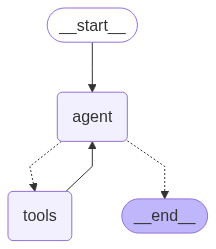

In [29]:
graph

# Run

In [47]:
from langchain_core.messages import SystemMessage, HumanMessage
system_prompt = SystemMessage(
    """
    You are a reasoning agent designed to solve problems by selecting and using tools when needed.

    You have access to the following tools:
    - retriever_transformer: Search and return information specifically about transformers library.
    - retriever_hugging_face_documentation: Search and return information about hugging face documentation, it includes the guide and Python code.
    - tavily_search: Search and return information about current events.

    Your job is to:
    1. Think step-by-step about how to solve the user's request.
    2. If a tool is needed, decide **which tool** is best and provide the **correct arguments** for it.

    The system will automatically call the tool for you — you do not need to write code or JSON.
    Just make sure to:
    - Select the correct tool.
    - Provide the correct arguments (matching the function schema).
    - Only request one tool at a time.
    - After receiving the result, continue provide your thought about the previous result.

    Once you have enough information, respond with:

    Final Answer: <your final answer here>

    Be precise, concise, and always follow this reasoning loop:
    Thought → [Tool Call if needed] → Observation → Repeat or Final Answer.
    """
)

In [48]:
def run_agent(user_input: str, is_thinking: bool = False):
    if not is_thinking:
        user_input = user_input + " /no_think"
    for event in graph.stream({"messages": [{"type": "system", "content": system_prompt.content}, {"type": "human", "content": user_input}]}, stream_mode="values"):
        last_message = event["messages"][-1]
        last_message.pretty_print()

In [51]:
run_agent("What is PhoBERT ? Who is behind that model, is there any variant of PhoBERT ?", is_thinking=False)

================================ Human Message =================================

Wha is PhoBERT ? Who is behind that model, is there any variant of PhoBERT ? /no_think
================================== Ai Message ==================================

<think>

</think>

Thought: I need to find information about PhoBERT, including who developed it and if there are any variants. I will use the retriever_hugging_face_documentation tool to search for this information.
Tool Calls:
  retriever_hugging_face_documentation (chatcmpl-tool-2c00cccc277a4f08abb9af56d4b49fab)
 Call ID: chatcmpl-tool-2c00cccc277a4f08abb9af56d4b49fab
  Args:
    query: PhoBERT model, who is behind it, variants of PhoBERT
================================= Tool Message =================================
Name: retriever_hugging_face_documentation

by Yuanzhi Li, S\u00e9bastien Bubeck, Ronen Eldan, Allie Del Giorno, Suriya Gunasekar and Yin Tat Lee.\n1. **[PhoBERT](https://huggingface.co/docs/transformers/model_doc/phobert)